In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm
import pandas as pd
from scipy import optimize
from autograd import grad

In [2]:
tau = 10.
eta_0 = 0.1
tau_adapt = 10.
rho_0 = 0.5
v = 0
delta_u = 1.
mu_M = 0.00001
mu_Q = 0.00001
tau_G = 10.
tau_baseline = 100.
dt = 1.

In [3]:
num_visible = 30
num_hidden = 30
num_neurons = num_visible + num_hidden
num_timebins = 1000

weights_M = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(weights_M, 0)

weights_Q = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(weights_Q, 0)

# no connections from visible->visible or hidden->visible in Q weights (top half of matrix)
weights_Q[:num_visible, :] = 0

phi = np.zeros(shape = (num_neurons, num_timebins))
rho = np.zeros(shape = (num_neurons, num_timebins))
eta = np.zeros(shape = (num_neurons, num_timebins))
u = np.zeros(shape = (num_neurons, num_timebins))
spikes = np.zeros(shape = (num_neurons, num_timebins))
spike_probs = np.zeros(shape = (num_neurons, num_timebins))

# phi[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
phi[:, 0] = np.zeros(num_neurons)
# eta[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
eta[:, 0] = np.zeros(num_neurons)
u[:, 0] = np.matmul(weights_M, phi[:, 0]) - eta[:, 0]
rho[:, 0] = rho_0 * np.exp(u[:, 0])
spike_probs[:, 0] = 1-np.exp(-rho[:, 0])
spikes[:, 0] = np.random.binomial(n = 1, p = spike_probs[:, 0])



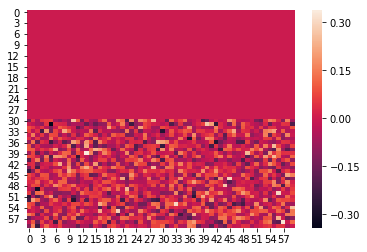

In [4]:
sns.heatmap(weights_Q)

In [5]:

for tt in range(1, num_timebins):
        
    for ii in range(num_neurons):
        
        dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
        deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])
        
        phi[:, tt] = phi[:, tt - 1] + dphi
        eta[:, tt] = eta[:, tt - 1] + deta
        
#         bool_array = (spikes[:, :tt] > 0).astype(int)
#         last_spike_time = tt - (np.argmax(bool_array[:, ::-1], axis=1))
#         s = np.ones(num_neurons) * tt - last_spike_time
#         eta[:, tt] = np.exp(-(dt * s) / tau_adapt)
                
        total_potential = np.matmul(weights_M, phi[:, tt]) - eta_0 * eta[:, tt]
        u[:, tt] = total_potential
        
        rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)
        
#         spikes[:, tt] = np.random.poisson(rho[:, tt])
        spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
        spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

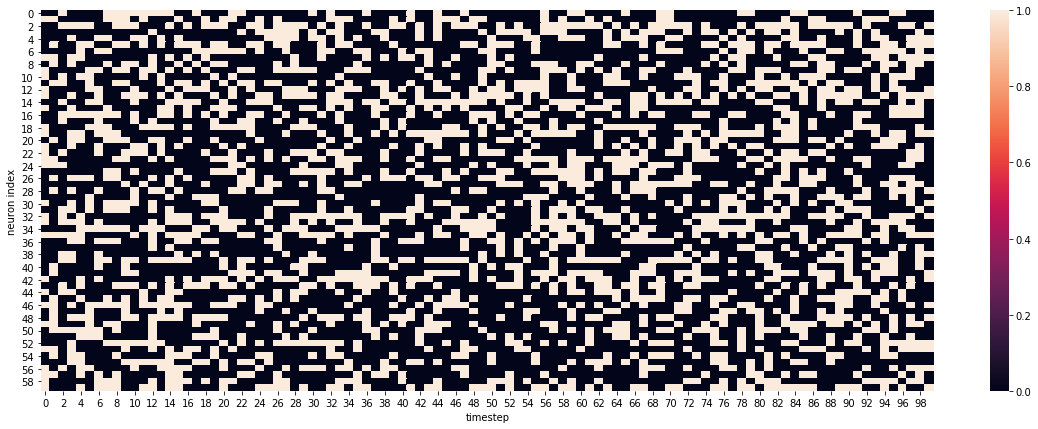

In [6]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(spikes[:, :100])
plt.xlabel("timestep")
plt.ylabel("neuron index")

In [ ]:
def M_network_grad(curr_weights_M):
    
    # M-network likelihood
    total_potential = np.matmul(curr_weights_M, phi) - eta_0 * eta[0, :]

    rho[0, :] = rho_0 * np.exp((total_potential - v) / delta_u)
    LL_M = np.sum(np.multiply(np.log(rho[0, :]), spikes[0, :]) - rho[0, :]) * dt

In [257]:
def log_likelihood(curr_weights_M, curr_weights_Q):

    # M-network likelihood
    total_potential = np.matmul(curr_weights_M, phi) - eta_0 * eta[0, :]

    rho[0, :] = rho_0 * np.exp((total_potential - v) / delta_u)
    LL_M = np.sum(np.multiply(np.log(rho[0, :]), spikes[0, :]) - rho[0, :]) * dt
    
    # Q-network likelihood
    total_potential = np.matmul(curr_weights_Q, phi) - eta_0 * eta[0, :]

    rho[0, :] = rho_0 * np.exp((total_potential - v) / delta_u)
    LL_Q = np.sum(np.multiply(np.log(rho[0, :]), spikes[0, :]) - rho[0, :]) * dt
    
    return -LL

In [258]:
x0 = np.random.normal(loc=0, scale=0.1, size=num_neurons)
res = optimize.minimize(log_likelihood, x0, options={'disp': True}, tol=1e-5)

Optimization terminated successfully.
         Current function value: 737.298201
         Iterations: 32
         Function evaluations: 1632
         Gradient evaluations: 51


In [259]:
print np.sum((res.x - weights[0, :])**2)

3.7680987025153327
